# Multi-Model Training and Comparison

## 1. Import Dependencies

In [190]:
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import confusion_matrix, f1_score

warnings.filterwarnings('ignore')

## 2. Load Processed Data

In [191]:
X_train = np.load('artifacts/X_train.npz')['arr_0']
Y_train = np.load('artifacts/Y_train.npz')['arr_0']
X_test = np.load('artifacts/X_test.npz')['arr_0']
Y_test = np.load('artifacts/Y_test.npz')['arr_0']

print("Data loaded successfully from artifacts.")

Data loaded successfully from artifacts.


## 3. Define Models and Cross-Validation Strategy

In [192]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

cv = StratifiedKFold(
    n_splits=6,
    random_state=42,
    shuffle=True
)

## 4. Train and Evaluate Models using Cross-Validation

We will train each model using cross-validation and select the best estimator based on the F1 score.

In [193]:
trained_models = {}
cv_f1_scores = {}

for model_name, model in models.items():
    print(f"--- Training {model_name} ---")
    
    cv_results = cross_validate(
        model,
        X_train,
        Y_train,
        cv=cv,
        scoring='f1',
        return_estimator=True,
        return_train_score=False
    )
    
    # Get the F1 scores and find the best estimator
    test_scores = cv_results['test_score']
    best_index = np.argmax(test_scores)
    best_estimator = cv_results['estimator'][best_index]
    
    trained_models[model_name] = best_estimator
    cv_f1_scores[model_name] = np.mean(test_scores)
    
    print(f"Average F1 Score: {np.mean(test_scores):.4f}")
    print(f"Best estimator from fold {best_index + 1} selected.")

print("\nAll models trained successfully.")

--- Training Logistic Regression ---
Average F1 Score: 0.7193
Best estimator from fold 4 selected.
--- Training Decision Tree ---
Average F1 Score: 0.8430
Best estimator from fold 3 selected.
--- Training Random Forest ---
Average F1 Score: 0.9055
Best estimator from fold 6 selected.

All models trained successfully.


## 5. Compare Model Performance on Test Set

In [194]:
Y_hat_tests = {}
test_f1_scores = {}

for model_name, model in trained_models.items():
    Y_hat_test = model.predict(X_test)
    Y_hat_tests[model_name] = Y_hat_test
    test_f1_scores[model_name] = f1_score(Y_test, Y_hat_test)

print("--- F1 Scores on Test Set ---")
for model_name, score in test_f1_scores.items():
    print(f"{model_name}: {score:.4f}")

--- F1 Scores on Test Set ---
Logistic Regression: 0.4581
Decision Tree: 0.4831
Random Forest: 0.5707


## 6. Visualize Confusion Matrices

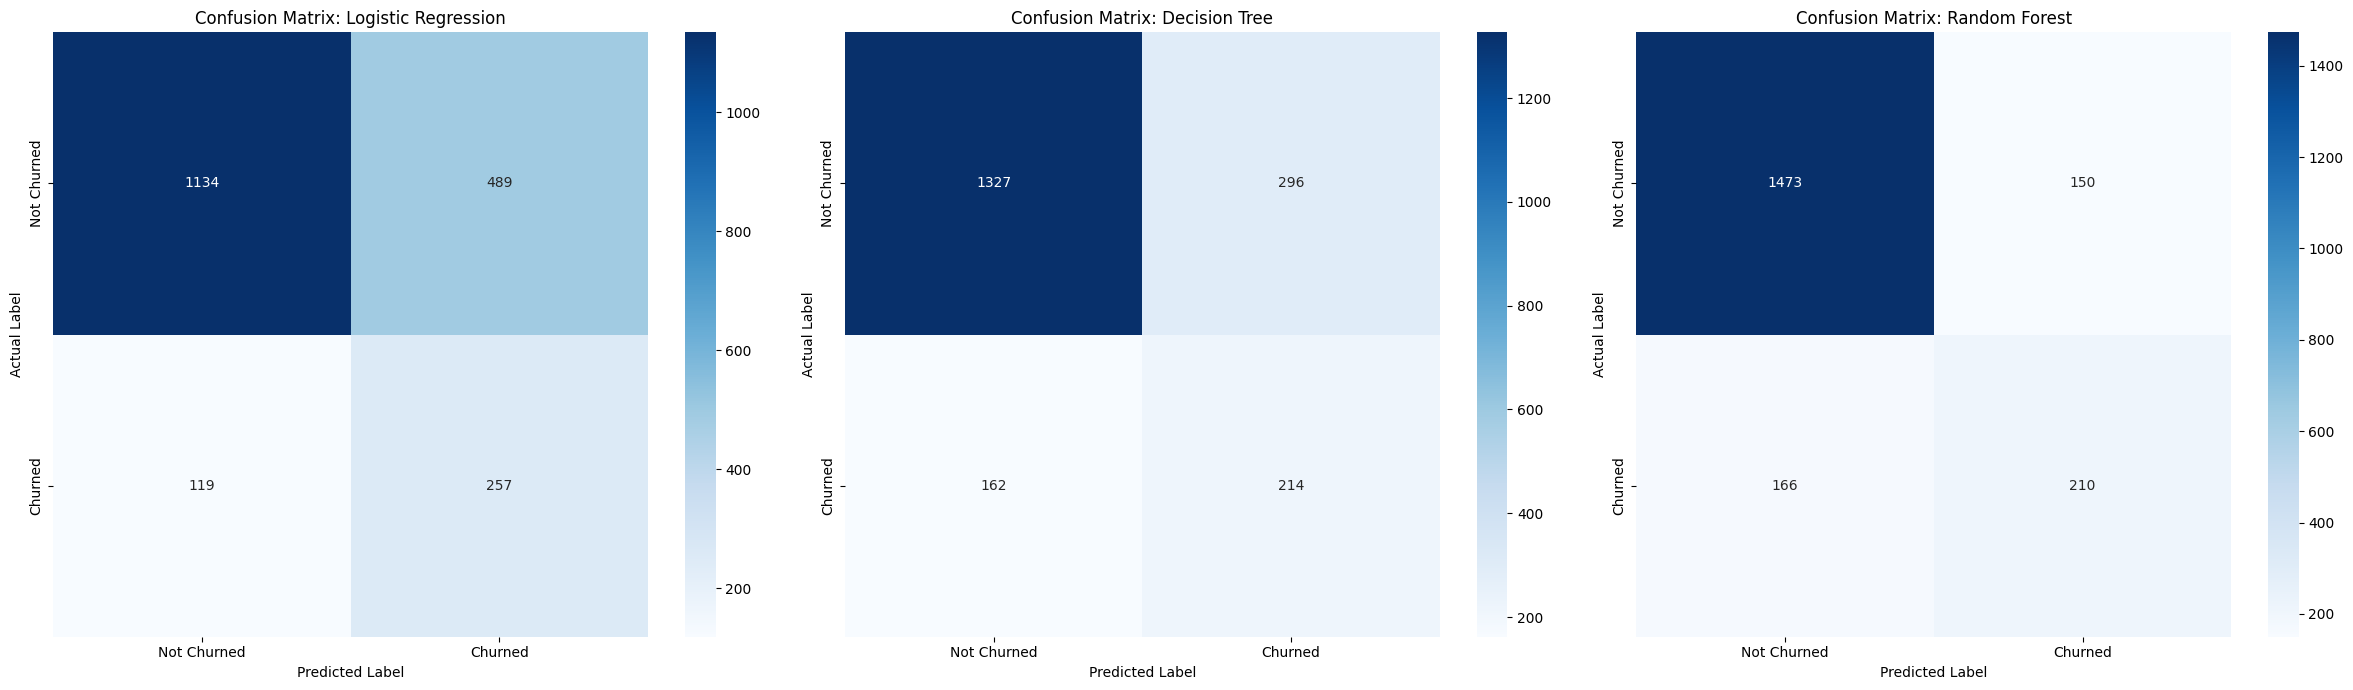

In [195]:
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

for ax, model_name in zip(axes, models.keys()):
    cm = confusion_matrix(Y_test, Y_hat_tests[model_name])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Not Churned', 'Churned'],
                yticklabels=['Not Churned', 'Churned'])
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('Actual Label')
    ax.set_title(f'Confusion Matrix: {model_name}')

plt.tight_layout()
plt.show()

## 7. Save the Best Model

In [196]:
best_model_name = max(test_f1_scores, key=test_f1_scores.get)
best_model = trained_models[best_model_name]

joblib.dump(best_model, 'model/best_model.pkl')

print(f"Best performing model ('{best_model_name}') saved to 'model/best_model.pkl'.")

Best performing model ('Random Forest') saved to 'model/best_model.pkl'.
